In [11]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


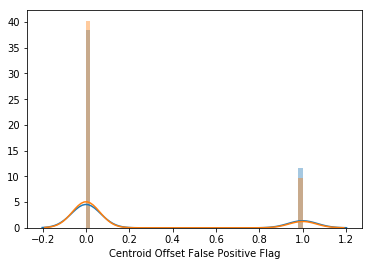

In [90]:
df = pd.read_csv('KeplerData.csv')
target = 'Exoplanet Archive Disposition'
subset_features = list(set(df.columns[4:]) - set(['Equilibrium Temperature Upper Uncertainty [K]', 'Equilibrium Temperature Lower Uncertainty [K]']))
subset = df[subset_features + [target]]
# list(df.columns[4:])
groups = df[['Orbital Period [days]', target]].groupby(target)
groups.mean()
for c in df.columns[6:8]:
    sns.distplot(df[c])

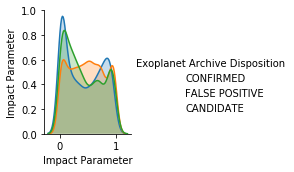

In [79]:
continous_features = [
 'Impact Parameter',
]
df2 = df[continous_features + [target]]
sns.pairplot(df2[df2 < 1].dropna(), hue=target)

In [55]:
confirmed = subset[subset['Exoplanet Archive Disposition'] == 'CONFIRMED']
fpositives = subset[subset['Exoplanet Archive Disposition'] == 'FALSE POSITIVE']
pd.DataFrame([
    [len(confirmed[confirmed['Not Transit-Like False Positive Flag'] == 0]),
    len(confirmed[confirmed['Not Transit-Like False Positive Flag'] == 1])],
    [len(fpositives[fpositives['Not Transit-Like False Positive Flag'] == 0]),
    len(fpositives[fpositives['Not Transit-Like False Positive Flag'] == 1])]
])

,0,1
0,2276,21
1,3244,1779


In [56]:
import seaborn as sns

# Iris dataset
from sklearn.datasets import load_iris

# Scikit's libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.externals.six import StringIO 
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn import metrics
from sklearn.metrics import make_scorer
import sklearn

# XGBoost
#import xgboost as xgb

# Pandas
import pandas as pd

# Numpy
import numpy as np
# Set random seed
np.random.seed(0)

# Plots
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import Image  
import pydotplus

In [126]:
subset2 = subset.dropna()
train, test = sklearn.model_selection.train_test_split(subset2)
y_train = train[target]
X_train = train[most_important]
y_test = test[target]
X_test = test[most_important]

In [127]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

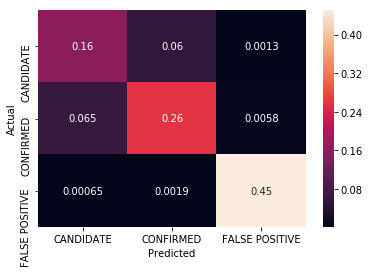

In [128]:
import seaborn as sns
confusion = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'], normalize=True)
sns.heatmap(confusion, annot=True)

In [129]:
cv_scores_rf = cross_val_score(clf, X_test, y_test, cv=5)

print("Mean Score:\t\t", np.mean(cv_scores_rf))
print("Completeness:\t\t", sklearn.metrics.recall_score(y_test, y_pred, average='micro'))
print("Contamination:\t\t", 1 - sklearn.metrics.precision_score(y_test, y_pred, average='micro'))
#sklearn.metrics.f1_score

Mean Score:		 0.8596429689946758
Completeness:		 0.8661060802069858
Contamination:		 0.13389391979301424


['Transit Duration Upper Uncertainty [hrs]',
 'Stellar Metallicity Upper Uncertainty [dex]',
 'Transit Signal-to-Noise',
 'Stellar Radius Lower Uncetainty [Solar radii]',
 'Stellar Eclipse False Positive Flag',
 'Transit Depth Lower Uncertainty [ppm]',
 'Maximum Multiple Event Statistic',
 'Dec [decimal degrees]',
 'PRF Delta Delta SQ (KIC) [arcsec]',
 'Centroid Offset False Positive Flag']

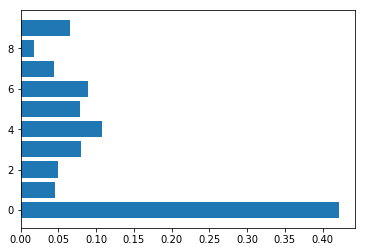

In [143]:
values = list(zip(subset_features, clf.feature_importances_))
plt.barh(range(len(clf.feature_importances_)), [x[1] for x in values])
sortd = sorted(values, reverse = True, key= lambda x: x[1])[:10]
most_important = [s[0] for s in sortd]

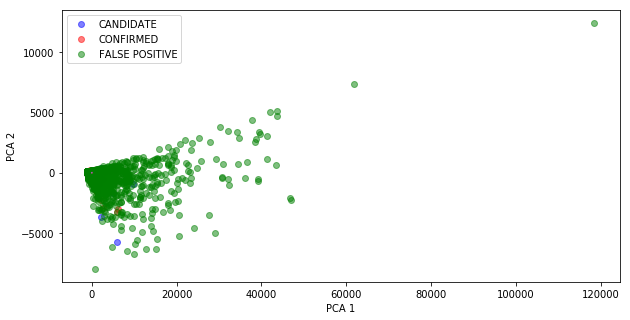

In [142]:
from sklearn import decomposition

iris = np.array(subset2[most_important])
species = subset2[target]
iris_colors = {'CANDIDATE': 'b', 'FALSE POSITIVE': 'g', 'CONFIRMED': 'r'}

pca = decomposition.PCA(n_components=2)
pca.fit(iris)
iris_pca = pca.transform(iris)

# projected coordinates
fig, ax = plt.subplots(figsize = (10, 5))
for specie in np.unique(species):
    mask = (species == specie)
    ax.scatter(iris_pca[mask][:, 0], iris_pca[mask][:, 1], label = specie, c = iris_colors[specie], alpha = 0.5)

# loading vectors
eviris = 2. * pca.components_
for idx, var in enumerate(subset2[most_important].columns[:-1]):
    ax.plot([0, eviris[0, idx]], [0, eviris[1, idx]])
    #ax.text(eviris[0, idx], eviris[1, idx], var)
ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.legend();

In [102]:
from sklearn.manifold import TSNE

tsne = TSNE(2, random_state=42)
X_tsne = tsne.fit_transform(subset2[most_important])

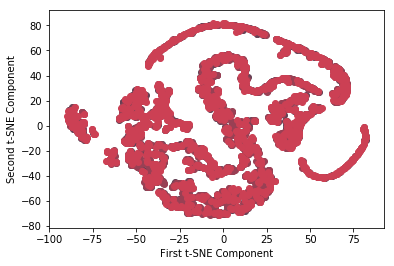

In [103]:
data_tsne = pd.DataFrame(X_tsne)
data_tsne[target] = subset2[target]

n = 1
for (category, row) in data_tsne.groupby(by=target):
    n = n + 1
    plt.scatter(row[0], row[1], color = (n*0.2, 0.25, 0.33, 1))

#plt.legend(data_tsne["category"].unique())
plt.xlabel("First t-SNE Component")
plt.ylabel("Second t-SNE Component")
plt.show()